<a href="https://colab.research.google.com/github/hugeinteger/InterFaceGAN/blob/master/colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before running make sure GPU usage is enabled.
Runtime->Change runtime type->GPU

In [1]:
!git clone https://github.com/ShenYujun/InterFaceGAN.git InterFaceGAN
import os
os.chdir("InterFaceGAN")

Cloning into 'InterFaceGAN'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 171 (delta 48), reused 153 (delta 36), pack-reused 0
Receiving objects: 100% (171/171), 2.07 MiB | 15.01 MiB/s, done.
Resolving deltas: 100% (48/48), done.


Mount google drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


Copy pretrained models from my google drive.</br>
StyleGAN - https://drive.google.com/open?id=1uka3a1noXHAydRPRbknqwKVGODvnmUBX </br>
ProGAN - https://drive.google.com/open?id=0B4qLcYyJmiz0NHFULTdYc05lX0U

In [0]:
# StyleGAN model pre-trained on celebahq dataset
!cp '/gdrive/My Drive/StyleGAN/networks/karras2019stylegan-celebahq-1024x1024.pkl' models/pretrain

# StyleGAN model pre-trained on ffhq dataset
!cp '/gdrive/My Drive/StyleGAN/networks/karras2019stylegan-ffhq-1024x1024.pkl' models/pretrain

# ProGAN model pre-trained on celebahq dataset
!cp '/gdrive/My Drive/ProgressiveGAN/networks/tensorflow-version/karras2018iclr-celebahq-1024x1024.pkl' models/pretrain

Generate images and latent codes.
Below calls could cause CuDNN version errors, but they disappear after re-runs.

In [14]:
#!mkdir data
!rm -rf data/stylegan_celebahq
!python generate_data.py -m stylegan_celebahq -o data/stylegan_celebahq -n 3
!rm -rf data/stylegan_ffhq
!python generate_data.py -m stylegan_ffhq -o data/stylegan_ffhq -n 3
!rm -rf data/pggan_celebahq
!python generate_data.py -m pggan_celebahq -o data/pggan_celebahq -n 3


[2019-09-05 21:07:40,642][INFO] Initializing generator.
[2019-09-05 21:07:40,958][INFO] Loading pytorch model from `models/pretrain/stylegan_celebahq.pth`.
[2019-09-05 21:07:41,281][INFO] Successfully loaded!
[2019-09-05 21:07:41,281][INFO]   `lod` of the loaded model is 0.0.
[2019-09-05 21:07:43,758][INFO] Preparing latent codes.
[2019-09-05 21:07:43,758][INFO]   Sample latent codes randomly.
[2019-09-05 21:07:43,759][INFO] Generating 3 samples.
[2019-09-05 21:07:44,418][INFO] Saving results.
[2019-09-05 21:07:47,448][INFO] Initializing generator.
[2019-09-05 21:07:47,762][INFO] Loading pytorch model from `models/pretrain/stylegan_ffhq.pth`.
[2019-09-05 21:07:48,081][INFO] Successfully loaded!
[2019-09-05 21:07:48,082][INFO]   `lod` of the loaded model is 0.0.
[2019-09-05 21:07:50,549][INFO] Preparing latent codes.
[2019-09-05 21:07:50,549][INFO]   Sample latent codes randomly.
[2019-09-05 21:07:50,549][INFO] Generating 3 samples.
[2019-09-05 21:07:51,181][INFO] Saving results.
[2019-

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

directory=os.listdir('data')
for each in directory:
    plt.figure(figsize=(15, 6))
    currentFolder = 'data/' + each
    i=1
    for fullpath in glob.glob(currentFolder + "/*.jpg"):
        #print(fullpath)
        img=mpimg.imread(fullpath)
        plt.subplot(2, 3, i)
        plt.imshow(img)
        ++i




/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


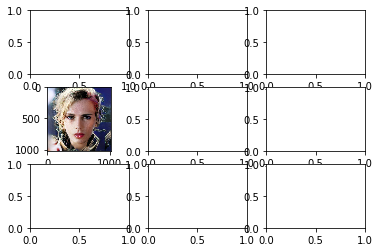

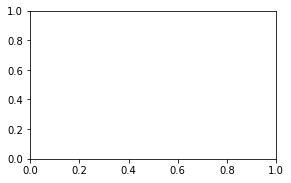

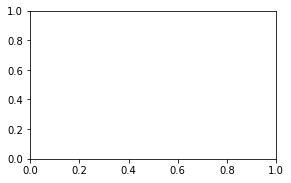

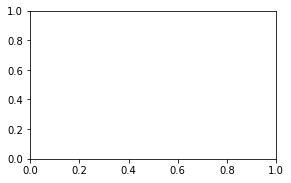

In [34]:
fig,ax = plt.subplots(3, 3)

directory=os.listdir('data')
for each in directory:
    plt.figure(figsize=(15, 6))
    currentFolder = 'data/' + each
    i=1
    for fullpath in glob.glob(currentFolder + "/*.jpg"):
      img=mpimg.imread(fullpath)
      plt.subplot(2, 3, i)
      ax[i%3][i//3].imshow(img)
      ++i
fig.show()

In [0]:
#!mkdir results
!rm -rf results/stylegan_celebahq_smile_editing
#!python edit.py -h
!python edit.py  -m stylegan_celebahq -b boundaries/stylegan_celebahq_smile_boundary.npy -i data/stylegan_celebahq/z.npy -o results/stylegan_celebahq_smile_editing 

[2019-09-04 13:05:58,228][INFO] Initializing generator.
[2019-09-04 13:05:58,531][INFO] Loading pytorch model from `models/pretrain/stylegan_celebahq.pth`.
[2019-09-04 13:05:58,864][INFO] Successfully loaded!
[2019-09-04 13:05:58,865][INFO]   `lod` of the loaded model is 0.0.
[2019-09-04 13:06:01,371][INFO] Preparing boundary.
[2019-09-04 13:06:01,383][INFO] Preparing latent codes.
[2019-09-04 13:06:01,383][INFO]   Load latent codes from `data/stylegan_celebahq/z.npy`.
[2019-09-04 13:06:01,384][INFO] Editing 10 samples.
[2019-09-04 13:06:18,039][INFO] Successfully edited 10 samples.
